# Comparing  Logistic Regression, Fully Connected NN, Convolutional NN and MobileNetV2

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##  Visualize samples from the data

Files already downloaded and verified


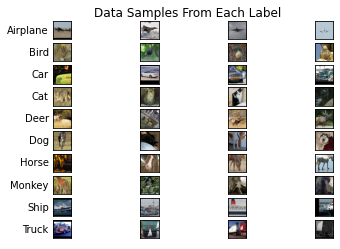

In [5]:
def VisualizeData(num_rows: int = 10, num_cols: int = 4):
    labels = {0: 'Airplane', 
              1: 'Bird', 
              2: 'Car', 
              3: 'Cat',
              4: 'Deer', 
              5: 'Dog', 
              6: 'Horse', 
              7: 'Monkey', 
              8: 'Ship', 
              9: 'Truck'}
    
    train_data = torchvision.datasets.STL10(root='./data', split='train', download=True)
    fig, axs = plt.subplots(nrows = num_rows, ncols = num_cols)
    
    for label in np.arange(num_rows):
        label_exists = (train_data.labels == label)
        image_index = np.where(label_exists == True)[0]
        for img_example in range(num_cols):
            image = train_data.data[image_index[img_example]]
            axs[label, img_example].imshow(image.transpose((1,2,0)))
            axs[label, img_example].xaxis.set_ticks([])
            axs[label, img_example].yaxis.set_ticks([])
            
        axs[label, 0].set_ylabel(labels[label], rotation = 'horizontal',
                                 verticalalignment = 'center',
                                 horizontalalignment = 'right')
    fig.suptitle('Data Samples From Each Label', y = 0.93)
    plt.show()
    
VisualizeData()

## Pre-processing the data

In [6]:
def DataProcessing(train_batch: int = 64, test_batch: int = 64, val_per: float = 0.2, seed: int = 0, crop: int = 64, mean: tuple = (0.5, 0.5, 0.5), std: tuple = (0.5, 0.5, 0.5)):
    train_transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean, std),
                                    transforms.RandomCrop(crop),
                                    transforms.RandomRotation(20),
                                    transforms.RandomAffine(5)])
        
    test_transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean, std),
                                    transforms.CenterCrop(crop)])
        
    train_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
    val_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=test_transform)
    test_data = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=test_transform)
        
    labels = train_data.labels
    train_arange = np.arange(len(train_data)) 
    train_idx, val_idx = train_test_split(train_arange, test_size=val_per, random_state=seed, shuffle=True, stratify=labels)
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch, sampler=train_sampler)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=train_batch, sampler=val_sampler)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch)
    
    return labels, train_data_loader, val_data_loader, test_data_loader


# Data Augmentation

Files already downloaded and verified
Files already downloaded and verified


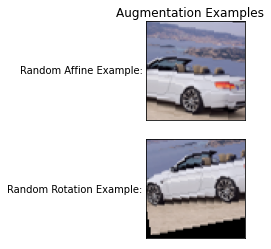

In [7]:
def ShowAugmentations(crop: int = 64):
    # Loading images
    random_affine = transforms.Compose([transforms.RandomAffine(5), 
                                        transforms.ToTensor(),
                                        transforms.RandomCrop(crop)]) 
    
    random_rotation = transforms.Compose([transforms.RandomRotation(20), 
                                        transforms.ToTensor(),
                                        transforms.RandomCrop(crop)])
    
    random_affine_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=random_affine)                                   
    random_rotation_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=random_rotation)
    
    random_affine_loader = torch.utils.data.DataLoader(random_affine_data)
    random_rotation_loader = torch.utils.data.DataLoader(random_rotation_data)
    
    # Read Augmented image data
    iter_random_affine = iter(random_affine_loader)
    iter_random_rotation = iter(random_rotation_loader)
    
    # take picture number 20
    pic_num = 20
    for _ in range(pic_num):
        random_affine_image, _ = iter_random_affine.next()
        random_rotation_image, _ = iter_random_rotation.next()
        
    # Convert image from tensor to numpy
    random_affine_image = random_affine_image.numpy()
    random_rotation_image = random_rotation_image.numpy()
    
    example_random_affine = np.transpose(random_affine_image[0],[1,2,0])
    example_random_rotation = np.transpose(random_rotation_image[0],[1,2,0])
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1)
    axs[0].imshow(example_random_affine)
    axs[0].xaxis.set_ticks([])
    axs[0].yaxis.set_ticks([])
    axs[0].set_ylabel('Random Affine Example:', rotation = 'horizontal',
                             verticalalignment = 'center',
                             horizontalalignment = 'right')
    
    axs[1].imshow(example_random_rotation)
    axs[1].xaxis.set_ticks([])
    axs[1].yaxis.set_ticks([])
    axs[1].set_ylabel('Random Rotation Example:', rotation = 'horizontal',
                             verticalalignment = 'center',
                             horizontalalignment = 'right')
    
    fig.suptitle('Augmentation Examples', y = 0.93)
    plt.show()
    
ShowAugmentations()

## Classification problem with different types of networks 

#### Multi-class Logistic Regression over flattened version of the images

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim: int = 64 * 64 * 3, output_dim: int = 10):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.fc_layer = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_layer(x)
        return x  

#### Fully-connected NN with 3 hidden layers over flattened version of the images followed by a classification layer

In [9]:
class FullyConnectedNN(nn.Module):
    def __init__(self, layers_size: list, dropout_per: float = 0.2):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.fc_layer1 = nn.Linear(layers_size[0], layers_size[1])
        self.batch_norm1 = nn.BatchNorm1d(layers_size[1])
        self.dropout1 = nn.Dropout(dropout_per)
        self.fc_layer2 = nn.Linear(layers_size[1], layers_size[2])
        self.batch_norm2 = nn.BatchNorm1d(layers_size[2])
        self.dropout2 = nn.Dropout(dropout_per)
        self.fc_layer3 = nn.Linear(layers_size[2], layers_size[3])
        self.batch_norm3 = nn.BatchNorm1d(layers_size[3])
        self.dropout3 = nn.Dropout(dropout_per)
        self.fc_output_layer = nn.Linear(layers_size[3], layers_size[4])
        
    def forward(self, x, activation_func: torch.nn.functional = F.relu):
        x = self.flatten(x)
        x = self.dropout1(activation_func(self.batch_norm1(self.fc_layer1(x))))
        x = self.dropout2(activation_func(self.batch_norm2(self.fc_layer2(x))))
        x = self.dropout3(activation_func(self.batch_norm3(self.fc_layer3(x))))
        x = self.fc_output_layer(x)
        return x

#### CNN with two convolution layers and two pooling layers followed by three fully connected layers

In [10]:
class CNN(nn.Module):
    def __init__(self, kernel_size: list, num_filters: list, fc_layers_size: list, input_channels: int = 3, pooling_size: int = 2, dropout_per: float = 0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_filters[0], kernel_size[0])
        self.batch_norm1 = nn.BatchNorm2d(num_filters[0])
        self.max_pool1 = nn.MaxPool2d(pooling_size, pooling_size)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size[1])
        self.batch_norm2 = nn.BatchNorm2d(num_filters[1])
        self.max_pool2 = nn.MaxPool2d(pooling_size, pooling_size)
        self.fc_layer1 = nn.Linear(fc_layers_size[0], fc_layers_size[1])
        self.dropout1 = nn.Dropout(dropout_per)
        self.fc_layer2 = nn.Linear(fc_layers_size[1], fc_layers_size[2])
        self.dropout2 = nn.Dropout(dropout_per)
        self.output_layer = nn.Linear(fc_layers_size[2], fc_layers_size[3])
        
    def forward(self, x, activation_func: torch.nn.functional = F.relu):
        x = self.max_pool1(activation_func((self.batch_norm1(self.conv1(x)))))
        x = self.max_pool2(activation_func((self.batch_norm2(self.conv2(x)))))
        x = x.view(-1, self.fc_layer1.in_features)#reshapes(flattens) tensor to fit the linear fc layer 
        x = self.dropout1(activation_func(self.fc_layer1(x)))
        x = self.dropout2(activation_func(self.fc_layer2(x)))
        x = self.output_layer(x)
        return x

In [11]:
# a function that calculates the size of the input to the first fully connected layer after the CNN
def InputSizeFcLayer1CNN(input_size: list, num_filters: list, kernel_size: list, pooling_size: int = 2):
    size_after_conv1 = [num_filters[0], input_size[1] - kernel_size[0] + 1, input_size[2] - kernel_size[0] + 1]
    # for pooling size 2X2 we remain with 25% of the pixels
    size_after_pooling1 = int(np.floor(np.sqrt((size_after_conv1[1] * size_after_conv1[2]) / np.power(pooling_size, 2))))
    size_after_pooling1 = [size_after_conv1[0], size_after_pooling1, size_after_pooling1]

    size_after_conv2 = [num_filters[1], size_after_pooling1[1] - kernel_size[1] + 1, size_after_pooling1[2] - kernel_size[1] + 1]
    size_after_pooling2 = int(np.floor(np.sqrt(((size_after_conv2[1] * size_after_conv2[2]) / np.power(pooling_size, 2)))))
    size_after_pooling2 = [size_after_conv2[0], size_after_pooling2, size_after_pooling2]

    fc_layer1_size = np.prod(size_after_pooling2)
    return fc_layer1_size        

#### A fixed pre-trained MobileNetV2 followed by three fully connected layers

In [12]:
class FixedMobileNetV2(nn.Module):
    def __init__(self, layers_size: list):
        super(FixedMobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        
        # Freeze mobilenet_v2 weights:
        for param in self.mobilenet_v2.parameters():
            param.requires_grad = False
          
        self.fc_layer1 = nn.Linear(self.mobilenet_v2.classifier[1].out_features, layers_size[0])
        self.fc_layer2 = nn.Linear(layers_size[0], layers_size[1])
        self.output_layer = nn.Linear(layers_size[1], layers_size[2])
    
    def forward(self, x, activation_func: torch.nn.functional = F.relu):
        x = activation_func(self.mobilenet_v2(x))
        x = activation_func(self.fc_layer1(x))
        x = activation_func(self.fc_layer2(x))
        x = self.output_layer(x)
        return x

#### Learning a pre-trained MobileNetV2 parameters followed by three fully connected layers

In [13]:
class LearnMobileNetV2(nn.Module):
    def __init__(self, layers_size: list):
        super(LearnMobileNetV2, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.fc_layer1 = nn.Linear(self.mobilenet_v2.classifier[1].out_features, layers_size[0])
        self.fc_layer2 = nn.Linear(layers_size[0], layers_size[1])
        self.output_layer = nn.Linear(layers_size[1], layers_size[2])
        
    def forward(self, x, activation_func: torch.nn.functional = F.relu):
        x = activation_func(self.mobilenet_v2(x))
        x = activation_func(self.fc_layer1(x))
        x = activation_func(self.fc_layer2(x))
        x = self.output_layer(x)
        return x

# Training a model and validating it using the Test function

In [24]:
def TrainNN(train_data: torch.utils.data.DataLoader, val_data: torch.utils.data.DataLoader, model, device, optim: str, lr: float = 0.001, epochs: int = 100, reg: float = 0.0001, momentum: float = 0.9):
    train_losses, train_accuracies, val_losses, val_accuracies = ([] for _ in range(4))
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=reg)
    elif optim == 'ADAM':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    
    try: 
        optimizer.zero_grad()
    except UnboundLocalError as err: 
        print('Optimizer should be "ADAM" or "SGD"')
        
    loss_func = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss ,total_correct ,train_total  = 0, 0, 0
        for batch_num, data in enumerate(train_data, 1):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients:
            optimizer.zero_grad()
            
            # forward + backward + optimize:
            predictions = model(features)
            loss = loss_func(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            #argmax to determine class:
            _, predicted = torch.max(predictions.data, 1)
            
            total_correct += sum(predicted == labels).item()
            train_total += labels.size(0)
            
        train_losses.append(total_loss / batch_num)
        train_accuracies.append(total_correct / train_total)
            
        val_accuracy, val_loss = Test(val_data, model, device)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
            
        print('epoch: ' + str(epoch + 1) + '\n train accuracy: ' + str(total_correct / train_total)
              + '\n val accuracy: ' + str(val_accuracy)
              + '\n train loss: ' + str(total_loss / batch_num) 
              + '\n val loss: ' + str(val_loss))
            
    print('Finished Training')
    return train_accuracies, train_losses, val_accuracies, val_losses, model

# Testing the model on the test data

In [15]:
def Test(test_data: torch.utils.data.dataloader, model, device):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    total_loss ,total_correct ,test_total  = 0, 0, 0
    with torch.no_grad():
        for batch_num, data in enumerate(test_data, 1):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)
            loss = loss_func(predictions, labels)
            total_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            test_total += labels.size(0)
            total_correct += sum((predicted == labels)).item()
               
    test_accuracy = total_correct / test_total
    test_loss = total_loss / batch_num
    return test_accuracy, test_loss

# Plot loss and accuracy functions vs epochs

In [21]:
def Plot(train_accuracies, train_losses, val_accuracies, val_losses, optim, lr, epochs, reg, model_name):
    steps = np.arange(epochs)
    fig, ax1 = plt.subplots()
    fig.suptitle(str(model_name), y = 0.95, fontsize = 13)
    plt.title('Learning Rate: ' + str(lr) 
              + ', Regularization Factor: ' 
              + str(reg) + ', Optimizer: ' 
              + str(optim), fontsize = 10)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(steps, train_losses, label = "train loss", color = 'red')
    ax1.plot(steps, val_losses, label = "validation loss", color = 'green')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Acccuracy')
    ax2.plot(steps, train_accuracies, label="train accuracy", color='blue')
    ax2.plot(steps, val_accuracies, label="validation accuracy", color='black')
    
    fig.legend(loc='center right', bbox_to_anchor=(0.85, 0.6))
    fig.tight_layout()
    plt.show()

# Main part - run all the models with the hyper-parameters that give the best results

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Test Accuracy: 0.30675
Test Loss: 1.947945475578308


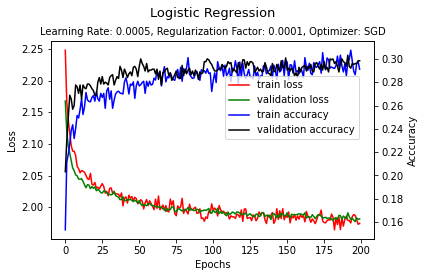


Test Accuracy: 0.443125
Test Loss: 1.5485912258662875


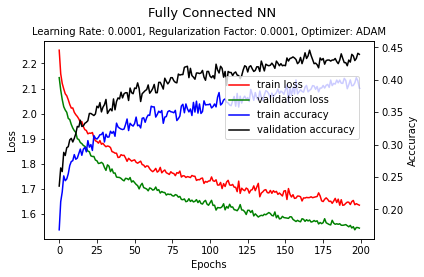


Test Accuracy: 0.623375
Test Loss: 1.0647281673219469


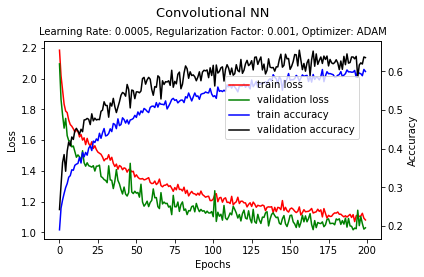


Test Accuracy: 0.658
Test Loss: 0.9920658658421229


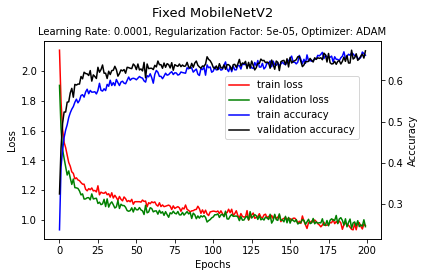


Test Accuracy: 0.801
Test Loss: 0.5659545484989409


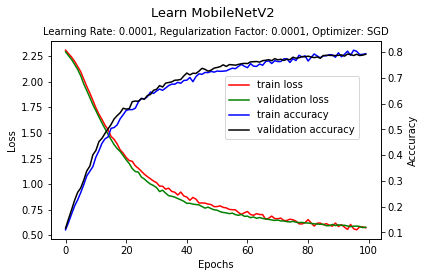

In [27]:
def main():   
    #VisualizeData()
    #ShowAugmentations()

    train_batch_size = 128
    test_batch_size = 128
    val_per = 0.25
    seed = 1

    # set cuda settings
    cuda = True
    use_cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = use_cuda
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    labels, train_data, val_data, test_data = DataProcessing(train_batch_size, test_batch_size, val_per, seed)
    num_labels = len(set(list(labels)))

    epochs = [200, 200, 200, 200, 100]
    lr = [0.0005, 0.0001, 0.0005, 0.0001, 0.0001]
    reg = [0.0001, 0.0001, 0.001, 5e-05, 0.0001]
    optim = ['SGD', 'ADAM', 'ADAM', 'ADAM', 'SGD']
    momentum = [0.2, 0, 0, 0, 0.9]

    # set model: LR
    input_size =  64 * 64 * 3
    output_size = num_labels
    LR = LogisticRegression(input_dim=input_size, output_dim=output_size).to(device)

    # set model: FCNN
    input_size = 3 * 64 * 64 
    layer1_size = 200
    layer2_size = 100
    layer3_size = 50
    output_layer_size = num_labels 
    layer_size = [input_size, layer1_size, layer2_size, layer3_size, output_layer_size]   
    dropout_percentage = 0.2
    FCNN = FullyConnectedNN(layers_size=layer_size, dropout_per=dropout_percentage).to(device)

    # set model: CNN
    input_size = [3, 64, 64]        
    kernel_size = [3, 3]
    num_filters = [20, 64]
    
    layer1_input_size = InputSizeFcLayer1CNN(input_size=input_size, num_filters=num_filters, kernel_size=kernel_size)
    layer1_size =  100
    layer2_size = 50
    output_layer_size = num_labels
    fc_layers_size = [layer1_input_size, layer1_size, layer2_size, output_layer_size]
    CNN_model = CNN(kernel_size=kernel_size, num_filters=num_filters, fc_layers_size=fc_layers_size).to(device)


    # set model: fixed MNV2:
    layers_size = [300, 100, num_labels]
    Fixed_MNV2 = FixedMobileNetV2(layers_size).to(device)

    # set model: learn MNV2:
    layers_size = [300, 100, num_labels]
    Learn_MNV2 = LearnMobileNetV2(layers_size) .to(device)

    models = [LR, FCNN, CNN_model, Fixed_MNV2, Learn_MNV2]
    model_name = ['Logistic Regression', 'Fully Connected NN', 'Convolutional NN', 'Fixed MobileNetV2', 'Learn MobileNetV2']

    for i, model in enumerate(models):
        train_accuracies, train_losses, val_accuracies, val_losses, model = TrainNN(train_data, val_data, model, device, optim[i], lr[i], epochs[i], reg[i], momentum[i])
        test_accuracy, test_loss = Test(test_data, model, device)
        print('\nTest Accuracy: ' + str(test_accuracy) + '\nTest Loss: ' + str(test_loss))
        Plot(train_accuracies, train_losses, val_accuracies, val_losses, optim[i], lr[i], epochs[i], reg[i], model_name[i])

if __name__ == '__main__':
    main()